### このコードではMNISTデータセットを使って，手書き数字を認識するモデルを作ります

# 今週の内容
- モデル
- 損失関数，最適化手法
- 学習，テスト用関数
- 学習と評価
- *結果をグラフで確認*

# ライブラリ

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

from tqdm import tqdm

# デバイス指定

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# 確認
print(device)

cpu


# ハイパーパラメータ

In [3]:
batch_size = 64
learning_rate = 0.01
num_epochs = 10

# データセット

In [4]:
train_dataset = datasets.MNIST(
    root = './data',
    train = True,
    transform = transforms.ToTensor(),
    download = True
)
train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True
)

test_dataset = datasets.MNIST(
    root = './data',
    train = False,
    transform = transforms.ToTensor()
)
test_loader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.14MB/s]


# モデル定義
- PyTorchにおいてnn.Moduleは、すべてのニューラルネットワークモジュールの基底クラスであり，訓練可能なパラメータの追跡，順伝播，逆伝播の管理など，基本的な機能を提供します

In [5]:
class Model(nn.Module): # nn.Moduleを継承したクラスを作成
    # モデルの構造を定義
    def __init__(self):
        super().__init__() # 親クラスのコンストラクタを呼び出す

        # Sequential: 実際のニューラルネットワークのアーキテクチャを定義
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
            nn.LogSoftmax(dim=1)
        )

    # 順方向の計算．入力データをどのようにモデルに通していくかを定義
    def forward(self, x: torch.Tensor):
        x = x.view(-1, 28*28) # 28x28の2次元データを1次元に変換する．28x28 -> 784
        x = self.model(x) # __init__で定義したモデルに通して計算
        return x

# 確認
model = Model()
model.to(device)

Model(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

# 損失関数＆最適化手法
- **損失関数**: モデルの予測が実際の正解からどれだけ離れているかを数値で表すものです．この値が小さいほど，モデルの予測は正確であると判断されます
<br>
<br>
- **最適化手法**: 損失関数を最小化するために，モデルのパラメータ（重みやバイアス）をどのように調整していくかを決めるアルゴリズムのことです

In [6]:
criterion = nn.NLLLoss() # Negative Log Likelihood

optimizer = torch.optim.SGD(
    model.parameters(), # 学習対象となるパラメータ
    lr=learning_rate # 学習率
)

# 学習用関数
- データローダーからミニバッチを取得し，順伝番，損失計算，逆伝番，パラメータ更新を繰り返します

In [7]:
def train_model(model, train_loader, optimizer, epoch, criterion):
    # モデルを訓練モードに設定。DropoutやBatchNormなどが訓練時と評価時で挙動を変えるため重要。
    model.train()

    # エポックごとの合計損失を初期化
    total_loss = 0.0
    # 正しく分類されたサンプルの数を初期化
    correct = 0
    # 処理された全サンプルの数を初期化
    total = 0

    # train_loaderからミニバッチを順に取得し、Tqdmで進捗バーを表示
    for images, labels in tqdm(train_loader):
        # 画像とラベルを適切なデバイス（GPUなど）に移動
        images = images.to(device)
        labels = labels.to(device)

        # 勾配をゼロにリセット。
        # 各ミニバッチの学習ステップで勾配を累積させないために必要。
        optimizer.zero_grad()

        # 順伝播：モデルに画像を入力し、出力を得る
        outputs = model(images)

        # 損失を計算：モデルの出力と正解ラベルを比較
        loss = criterion(outputs, labels)

        # 逆伝播：損失に基づいてモデルの各パラメータの勾配を計算
        loss.backward()

        # パラメータを更新：計算された勾配を使ってモデルの重みを調整
        optimizer.step()

        # 損失を累積（Pythonの数値に変換するため.item()を使用）
        total_loss += loss.item()

        # 予測クラスを取得：モデルの出力（LogSoftmax）の最大値のインデックスが予測クラス
        pred = outputs.argmax(dim=1, keepdim=True)

        # 正解数をカウント：予測と正解ラベルが一致する数を集計
        # labels.view_as(pred)でラベルの形状を予測に合わせる
        correct += pred.eq(labels.view_as(pred)).sum().item()

        # 処理された画像の総数をカウント（現在のミニバッチのサイズを加算）
        total += images.size(0)

    # エポック終了後の平均損失を計算
    avg_loss = total_loss / len(train_loader)
    # エポック終了後の精度を計算（パーセンテージ）
    accuracy = 100. * correct / total

    # エポックの進捗と結果を表示
    print(f'Epoch {epoch+1} / {num_epochs}') # num_epochsは関数外で定義されていると仮定
    print(f'訓練セット: 損失: {avg_loss:<8.4f}, 精度: {accuracy:.2f}%')

    # 平均損失と精度を返す
    return avg_loss, accuracy

# テスト用関数
- 訓練済みのニューラルネットワークが，まだ見たことないデータに対してどのくらいの性能を発揮するかを評価します
- 訓練中に使われなかったテストセットを使うことで，モデルの汎化性能を測ります

In [8]:
def test_model(model, test_loader, criterion):
    # モデルを評価モード切り替え
    # モデルを「評価モード」に設定します。これは、Dropout層やBatchNorm層などの層が
    # 訓練時と評価時で異なる振る舞いをすることから重要です。
    # 評価モードでは、Dropout層は無効化され、BatchNormはバッチの統計情報ではなく、
    # 訓練中に学習された統計情報（平均と分散）を使用します。
    model.eval()

    # テストセット全体の合計損失を初期化します。
    test_loss = 0.0

    # 正しく予測されたサンプルの数を初期化します。
    correct = 0

    # 勾配計算を無効にします。推論（評価）時には勾配を計算する必要がないため（逆伝播や重みの更新を行わないため）、これは非常に重要です。
    # メモリを節約し、計算を高速化する効果もあります。
    with torch.no_grad():

        # test_loaderからミニバッチのデータとその対応するラベルを順に取得します。
        for data, target in test_loader:

            # 入力データと正解ラベルを、指定されたデバイス（例：GPU）に移動します。
            data = data.to(device)
            target = target.to(device)

            # 順伝播を実行します：モデルに入力データを渡し、予測された出力を取得します。
            outputs = model(data)

            # 現在のミニバッチの損失を、定義済みの基準（例：nn.NLLLoss）を使って計算します。
            # .item()は損失を標準のPython数値として抽出し、合計テスト損失に加算されます。
            test_loss += criterion(outputs, target).item()



            # 予測されたクラスを取得します。LogSoftmax出力を持つ分類モデルの場合、argmaxは最も高い対数確率を持つインデックスを返します。これが予測されたクラスです。
            # dim=1はクラスの次元に沿って最大値を見つけることを指定
            # keepdim=Trueは比較しやすいように出力形状を保持します
            predicted = outputs.argmax(dim=1, keepdim=True)


            # 予測されたクラスと実際の正解ラベルを比較します。
            # (predicted == target)は、正しい予測の場合にTrueとなるブールテンソルを作成します。
            # .sum()はTrueの数（正しい予測の数）をカウントします。
            # .item()はテンソルの合計をPythonの数値に変換し、'correct'に加算します。
            correct += (predicted == target).sum().item()

    # バッチごとの平均テスト損失を計算します。
    test_loss /= len(test_loader)

    # 全体的な精度をパーセンテージで計算します。
    # len(test_loader.dataset)は、テストデータセットの全サンプル数を示します。
    accuracy = 100. * correct / len(test_loader.dataset)

    # 評価結果（平均テスト損失、正しく予測された数、テストサンプルの総数、計算された精度）を表示します。
    print(f'テストセット: 損失: {test_loss:.4f}, 精度: {correct} / {len(test_loader.dataset)} ({accuracy:.2f}%)\n')

    # 平均テスト損失と精度を返します。
    return test_loss, accuracy

# 学習と評価
- モデルを学習させ，その都度テストデータで性能を確認します

In [9]:
train_losses = list()   # 各エポックの訓練損失を保存するためのリスト
train_accuracy = list() # 各エポックの訓練精度を保存するためのリスト
test_losses = list()    # 各エポックのテスト損失を保存するためのリスト
test_accuracy = list()  # 各エポックのテスト精度を保存するためのリスト

# num_epochs回、訓練とテストのサイクルを繰り返す
for epoch in range(num_epochs):
    # 訓練ステップの実行
    # train_model関数を呼び出し、モデルを1エポック分訓練します。
    # 訓練中の平均損失と精度が返されます。
    avg_loss, accuracy = train_model(model, train_loader, optimizer, epoch, criterion)

    # 訓練結果をリストに記録
    train_losses.append(avg_loss)
    train_accuracy.append(accuracy)

    # テストステップの実行
    # test_model関数を呼び出し、訓練後のモデルをテストデータで評価します。
    # テスト時の平均損失と精度が返されます。
    test_loss, accuracy = test_model(model, test_loader, criterion)

    # テスト結果をリストに記録
    test_losses.append(test_loss)
    test_accuracy.append(accuracy)

100%|██████████| 938/938 [00:12<00:00, 77.12it/s]


Epoch 1 / 10
訓練セット: 損失: 1.6502  , 精度: 59.33%
テストセット: 損失: 0.7122, 精度: 69468 / 10000 (694.68%)



100%|██████████| 938/938 [00:11<00:00, 79.52it/s]


Epoch 2 / 10
訓練セット: 損失: 0.5211  , 精度: 86.37%
テストセット: 損失: 0.3968, 精度: 69891 / 10000 (698.91%)



100%|██████████| 938/938 [00:11<00:00, 81.25it/s]


Epoch 3 / 10
訓練セット: 損失: 0.3792  , 精度: 89.32%
テストセット: 損失: 0.3392, 精度: 69993 / 10000 (699.93%)



100%|██████████| 938/938 [00:11<00:00, 81.47it/s]


Epoch 4 / 10
訓練セット: 損失: 0.3320  , 精度: 90.50%
テストセット: 損失: 0.3006, 精度: 70102 / 10000 (701.02%)



100%|██████████| 938/938 [00:11<00:00, 82.34it/s]


Epoch 5 / 10
訓練セット: 損失: 0.3030  , 精度: 91.27%
テストセット: 損失: 0.2783, 精度: 70134 / 10000 (701.34%)



100%|██████████| 938/938 [00:11<00:00, 84.15it/s]


Epoch 6 / 10
訓練セット: 損失: 0.2804  , 精度: 92.01%
テストセット: 損失: 0.2613, 精度: 70224 / 10000 (702.24%)



100%|██████████| 938/938 [00:11<00:00, 81.26it/s]


Epoch 7 / 10
訓練セット: 損失: 0.2607  , 精度: 92.48%
テストセット: 損失: 0.2441, 精度: 70281 / 10000 (702.81%)



100%|██████████| 938/938 [00:11<00:00, 79.39it/s]


Epoch 8 / 10
訓練セット: 損失: 0.2437  , 精度: 93.05%
テストセット: 損失: 0.2273, 精度: 70279 / 10000 (702.79%)



100%|██████████| 938/938 [00:11<00:00, 79.08it/s]


Epoch 9 / 10
訓練セット: 損失: 0.2286  , 精度: 93.47%
テストセット: 損失: 0.2170, 精度: 70315 / 10000 (703.15%)



100%|██████████| 938/938 [00:11<00:00, 79.22it/s]


Epoch 10 / 10
訓練セット: 損失: 0.2141  , 精度: 93.92%
テストセット: 損失: 0.2004, 精度: 70389 / 10000 (703.89%)



# グラフ化
- epochごとの学習結果（損失，精度）をグラフで描画する

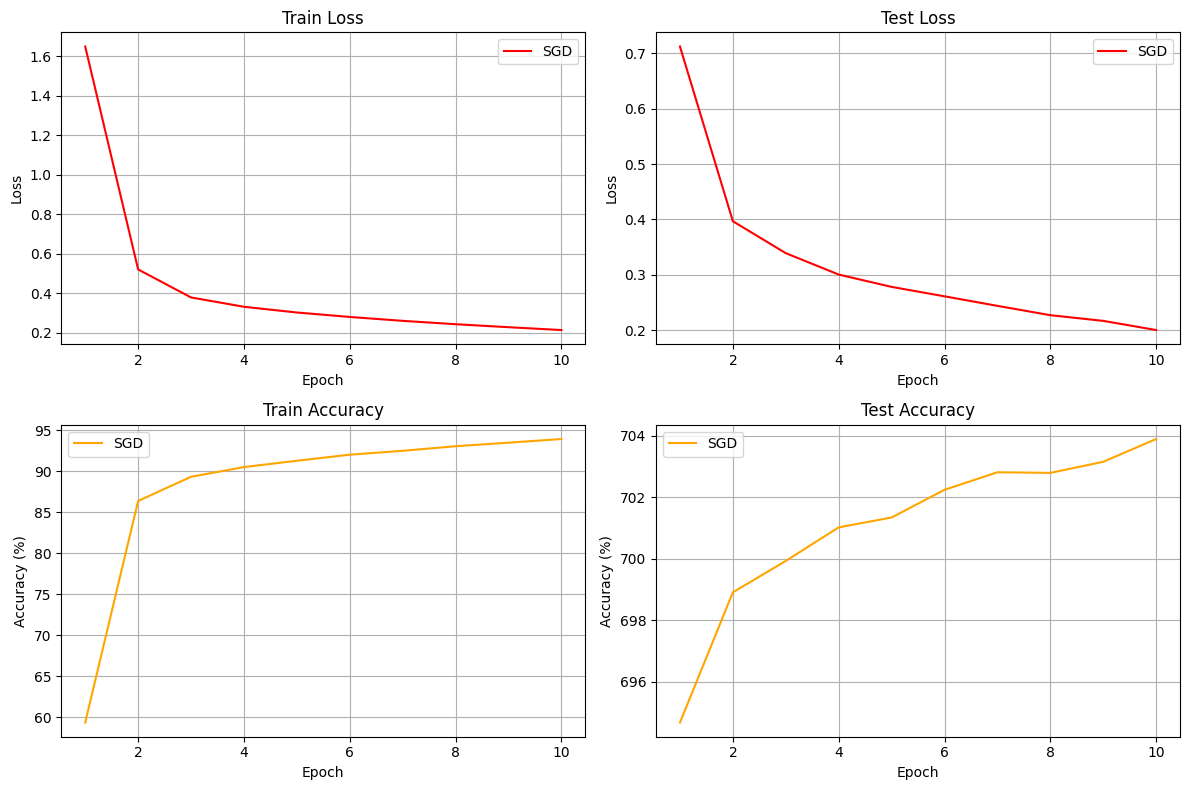

In [10]:
plt.figure(figsize=(12, 8))

# ---- 損失（訓練）----
plt.subplot(2, 2, 1) # 2x2のグリッドの1番目の位置にサブプロットを作成
plt.plot(range(1, num_epochs + 1), train_losses, label='SGD', color='r') # 訓練損失を折れ線グラフで描画
plt.xlabel('Epoch')   # X軸のラベルを「Epoch」に設定
plt.ylabel('Loss')    # Y軸のラベルを「Loss」に設定
plt.title('Train Loss') # グラフのタイトルを「Train Loss」に設定
plt.legend()          # 凡例（この場合は「SGD」）を表示
plt.grid(True)        # グリッド（方眼線）を表示

# ---- 損失（テスト）----
plt.subplot(2, 2, 2) # 2x2のグリッドの2番目の位置にサブプロットを作成（右上）
plt.plot(range(1, num_epochs + 1), test_losses, label='SGD', color='r') # テスト損失を折れ線グラフで描画
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()
plt.grid(True)

# ---- 精度（訓練）----
plt.subplot(2, 2, 3) # 2x2のグリッドの3番目の位置にサブプロットを作成（左下）
plt.plot(range(1, num_epochs + 1), train_accuracy, label='SGD', color='orange') # 訓練精度を折れ線グラフで描画
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)') # Y軸のラベルを「Accuracy (%)」に設定
plt.title('Train Accuracy') # グラフのタイトルを「Train Accuracy」に設定
plt.legend()
plt.grid(True)

# ---- 精度（テスト）----
plt.subplot(2, 2, 4) # 2x2のグリッドの4番目の位置にサブプロットを作成（右下）
plt.plot(range(1, num_epochs + 1), test_accuracy, label='SGD', color='orange') # テスト精度を折れ線グラフで描画
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout() # サブプロット間の間隔を自動調整して、重なりを防ぐ
plt.show()         # 作成した全てのグラフを表示